In [23]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [24]:
path = r".\..\..\Datos_Proyecto"

df_observations = pd.read_csv(r".\..\..\Datos_Proyecto\observations.csv")

**CHECK FOR NA VALUES ON DATA**

In [25]:
for csv in os.listdir(path):
    df = pd.read_csv(os.path.join(path, csv)) 
    print(f"{csv}:\n{df.isna().sum()}\n")

cloudiness.csv:
cloudiness       0
cloudiness_id    0
dtype: int64

dates.csv:
date       0
date_id    0
dtype: int64

observations.csv:
date_id               0
precipitation      2500
temp_max           2500
temp_min           2500
wind               2500
humidity              0
pressure              0
solar_radiation       0
visibility            0
weather_id            0
cloudiness_id         0
estacion_id           0
dtype: int64

seasons.csv:
estacion       0
estacion_id    0
dtype: int64

weather.csv:
weather       0
weather_id    0
dtype: int64



VISUALIZACION DE VALORES NULOS

In [26]:
# 2. Resumen de los datos nulos
print("Resumen de valores nulos por columna:")
print(df_observations.isnull().sum())

# 3. Total de nulos
total_nulos = df_observations.isnull().sum().sum()
print(f"\nTotal de valores nulos en el DataFrame: {total_nulos}")

# 4. Porcentaje de datos nulos por columna
porcentaje_nulos = (df_observations.isnull().sum() / len(df_observations)) * 100
print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos)

Resumen de valores nulos por columna:
date_id               0
precipitation      2500
temp_max           2500
temp_min           2500
wind               2500
humidity              0
pressure              0
solar_radiation       0
visibility            0
weather_id            0
cloudiness_id         0
estacion_id           0
dtype: int64

Total de valores nulos en el DataFrame: 10000

Porcentaje de valores nulos por columna:
date_id             0.0
precipitation      10.0
temp_max           10.0
temp_min           10.0
wind               10.0
humidity            0.0
pressure            0.0
solar_radiation     0.0
visibility          0.0
weather_id          0.0
cloudiness_id       0.0
estacion_id         0.0
dtype: float64


<Figure size 1500x1000 with 0 Axes>

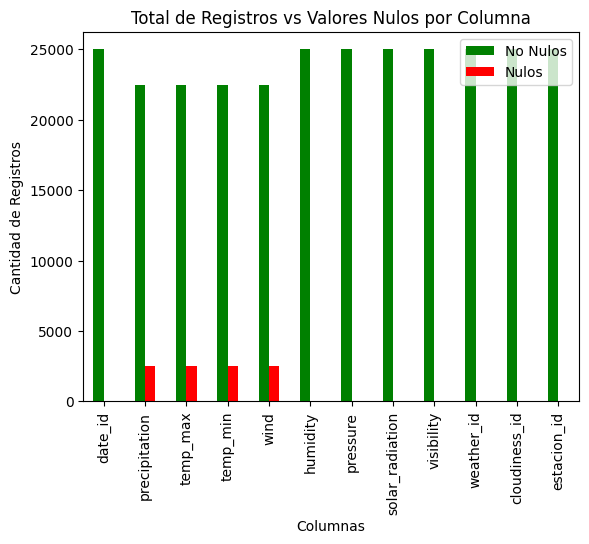

In [27]:
# Calcular la cantidad de valores nulos por columna
null_counts = df_observations.isnull().sum()

# Calcular el total de registros por columna
total_counts = df_observations.shape[0]

# Crear una nueva DataFrame con los datos para graficar
data = pd.DataFrame({
    'No Nulos': total_counts - null_counts.values,
    'Nulos': null_counts.values
}, index=null_counts.index)

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Crear el gráfico de barras apiladas (gráfico de columnas agrupadas)
data.plot(kind='bar', stacked=False, color=['green', 'red'])

# Títulos y etiquetas
plt.title("Total de Registros vs Valores Nulos por Columna")
plt.xlabel("Columnas")
plt.ylabel("Cantidad de Registros")
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si es necesario

# Agregar leyenda
plt.legend(["No Nulos", "Nulos"])

# Mostrar el gráfico
plt.show()

       precipitation      temp_max      temp_min          wind
count   22500.000000  22500.000000  22500.000000  22500.000000
mean       27.752615     16.967502      3.657439      4.929624
std        16.027512     10.678786      6.663217      2.627122
min         0.000950     -1.599122     -7.099699      0.400440
25%        14.013100      7.786814     -1.871769      2.649068
50%        27.510842     16.977533      2.803611      4.921028
75%        41.429830     26.115989      8.758843      7.197403
max        55.899713     35.599908     18.297301      9.498636


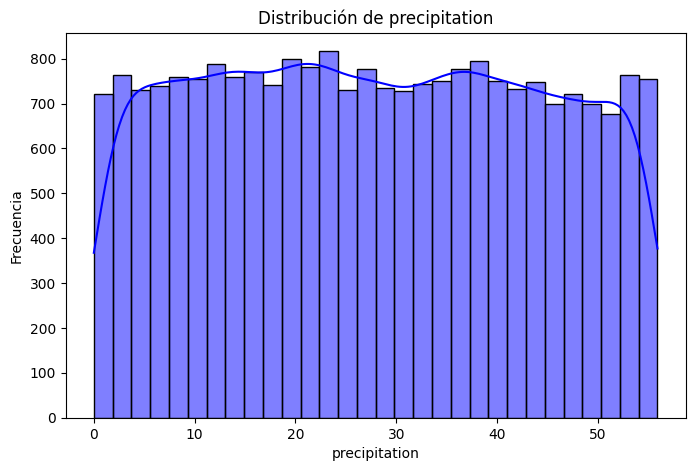

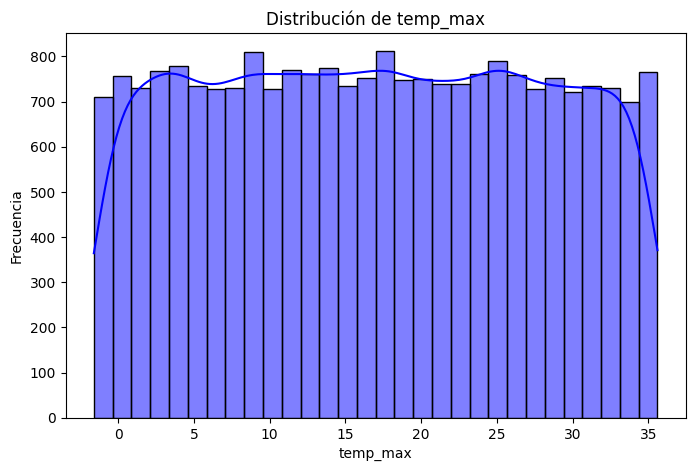

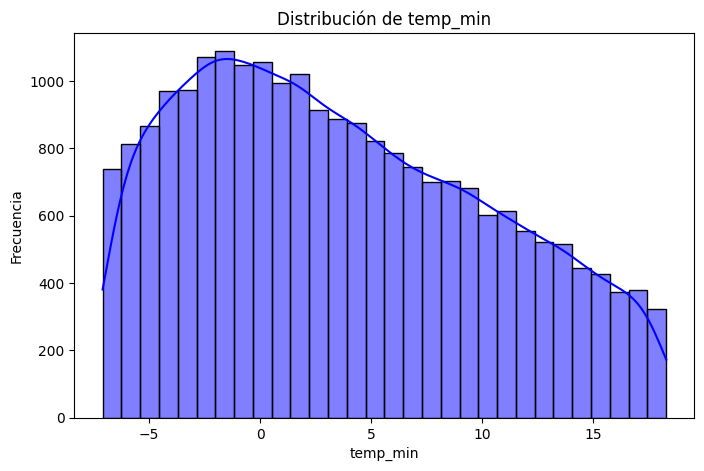

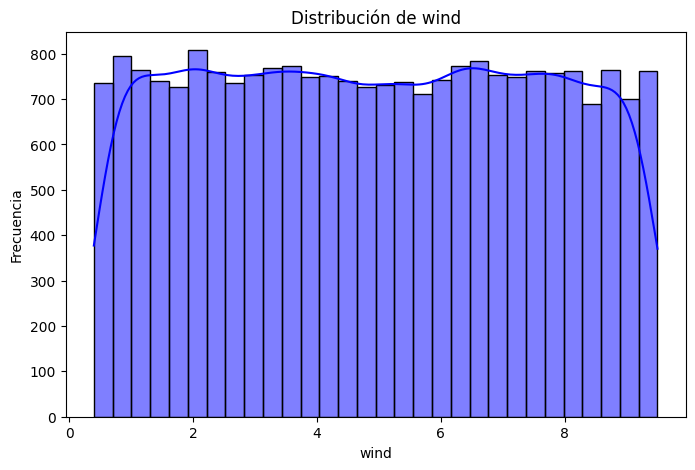

In [28]:
# Estadísticas descriptivas de las columnas con nulos
cols_nulos = ['precipitation', 'temp_max', 'temp_min', 'wind']
print(df_observations[cols_nulos].describe())

# Histograma de cada columna
for col in cols_nulos:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_observations[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

**ANALISIS DE DATOS CON NULOS**

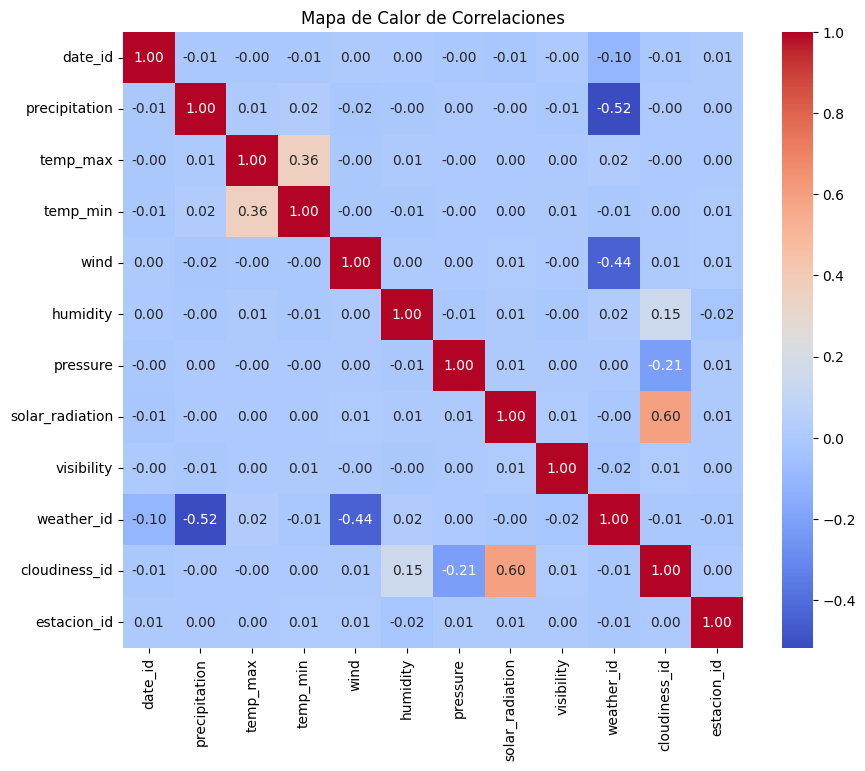

In [29]:
numerical_df_observations = df_observations.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_df_observations.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()


**VISUALIZAR LOS DATOS QUE RESALTAN EN EL GRÁFICO DE CORRELACIONES**

WEATHER_ID

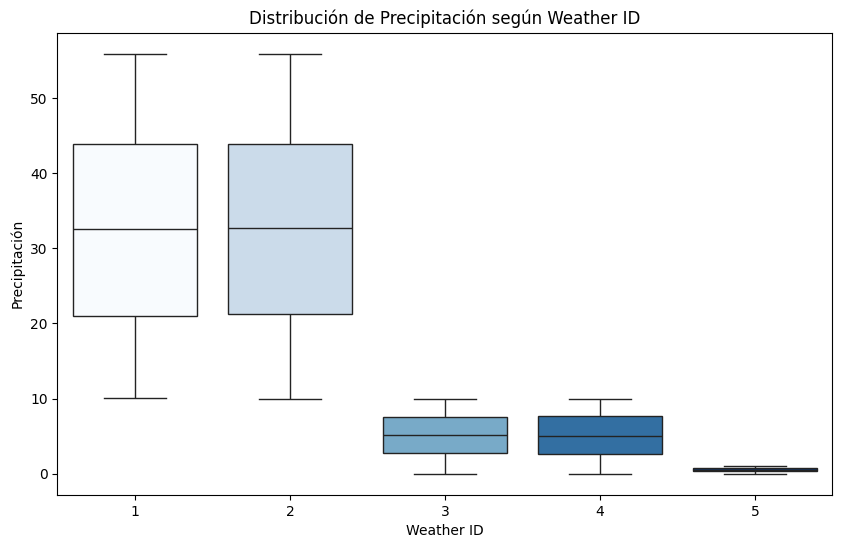

C:\Users\joant\AppData\Local\Temp\ipykernel_12332\32320975.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weather_id', y='wind', data=df_observations, palette='Greens')


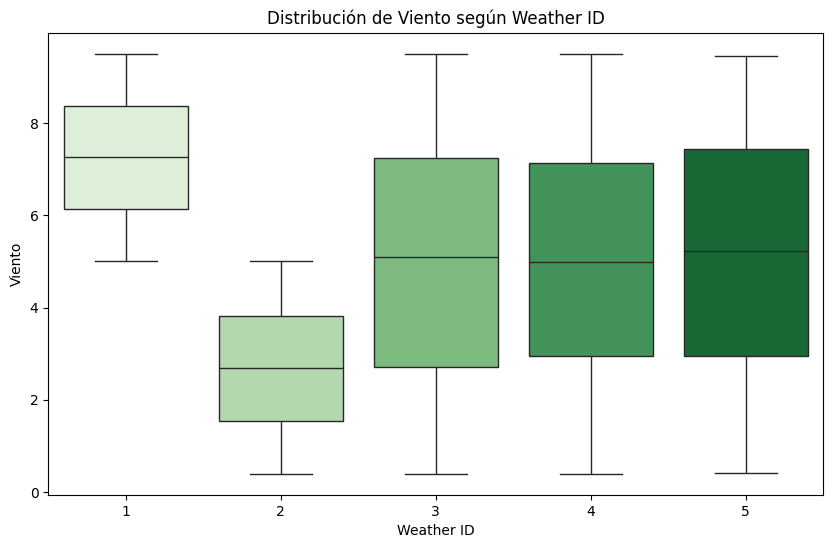

In [30]:
# Boxplot de weather_id vs precipitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='precipitation', hue='weather_id', data=df_observations, palette='Blues', legend=False)
plt.title('Distribución de Precipitación según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Precipitación')
plt.show()

# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='wind', data=df_observations, palette='Greens')
plt.title('Distribución de Viento según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Viento')
plt.show()

C:\Users\joant\AppData\Local\Temp\ipykernel_12332\3142211584.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cloudiness_id', y='solar_radiation', data=df_observations, palette='Reds')


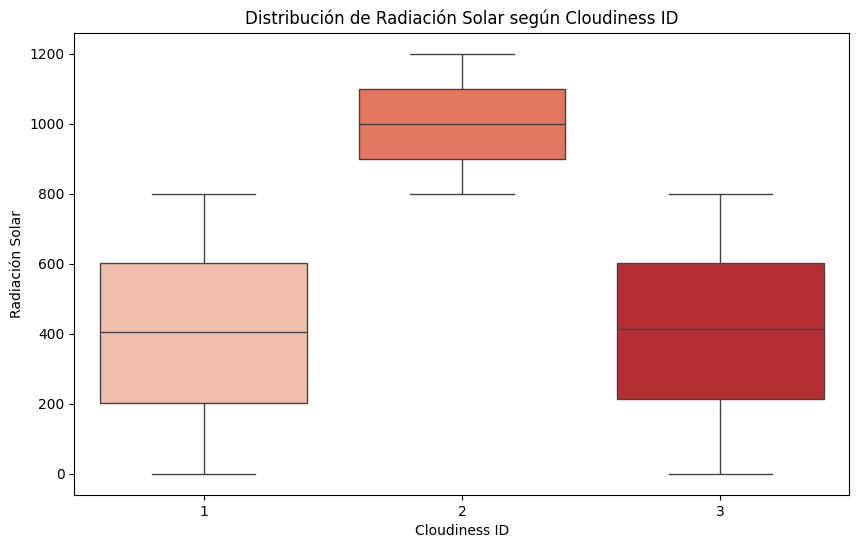

In [31]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='cloudiness_id', y='solar_radiation', data=df_observations, palette='Reds')
plt.title('Distribución de Radiación Solar según Cloudiness ID')
plt.xlabel('Cloudiness ID')
plt.ylabel('Radiación Solar')
plt.show()

**METODOS DE IMPUTACIÓN DE VALORES NULOS**

Imputar con los valores previos y posteriores del valor nulo.

Reorganizar el csv eliminando date_id y añadiendo la fecha

In [32]:
df_dates = pd.read_csv(r".\..\..\Datos_Proyecto\dates.csv")  # Archivo con las fechas

# Unir la fecha al DataFrame principal
df_observations = df_observations.merge(df_dates, on='date_id', how='left')

# Convertir la fecha a formato datetime y extrae
df_observations['date'] = pd.to_datetime(df_observations['date'])
df_observations.insert(0, 'date', df_observations.pop('date'))
df_observations.pop('date_id')

# ordenar por 'date'
df_observations = df_observations.sort_values(by='date')

# Calcular las medias por estación y año para las columnas con valores nulos
columns_to_impute = ['precipitation', 'temp_max', 'temp_min', 'wind']

for col in columns_to_impute:
    df_observations[col] = df_observations[col].interpolate(method='linear', limit_direction='both')

df_observations.to_csv(r".\..\..\Datos_Proyecto\observations_full.csv", index=False)



**ANALISIS DE DATOS CON NULOS IMPUTADOS**

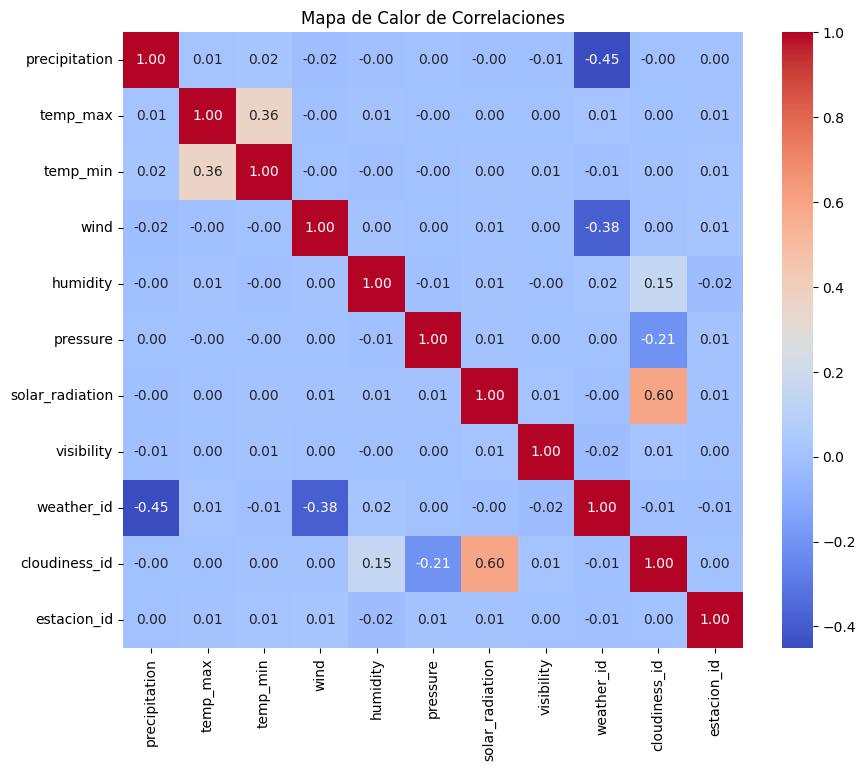

In [33]:
df_full = pd.read_csv(r".\..\..\Datos_Proyecto\observations_full.csv")

numerical_data = df_full.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

       precipitation      temp_max      temp_min          wind
count   25000.000000  25000.000000  25000.000000  25000.000000
mean       27.705473     16.945308      3.639998      4.925901
std        15.627353     10.429545      6.501064      2.562881
min         0.000950     -1.599122     -7.099699      0.400440
25%        14.549274      8.182007     -1.673610      2.758433
50%        27.485519     16.936219      2.849228      4.913406
75%        40.736396     25.683873      8.489202      7.089572
max        55.899713     35.599908     18.297301      9.498636


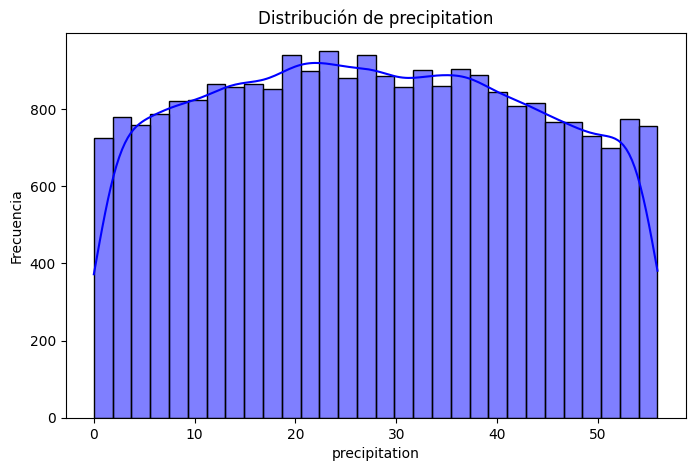

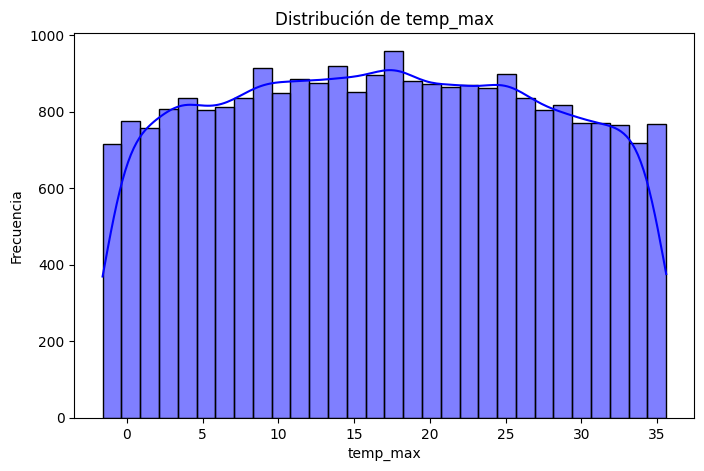

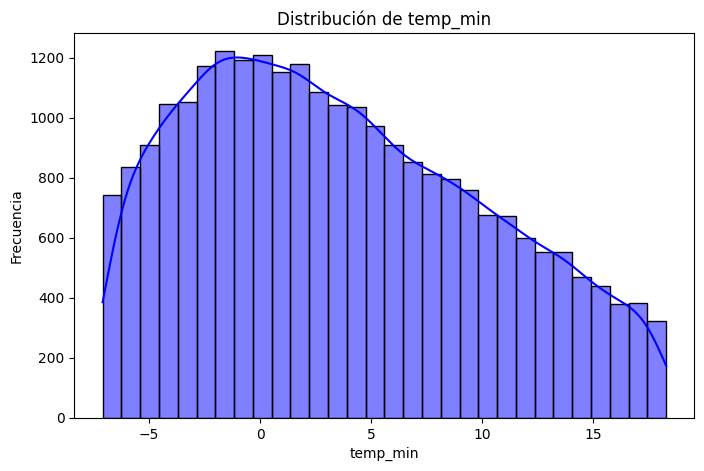

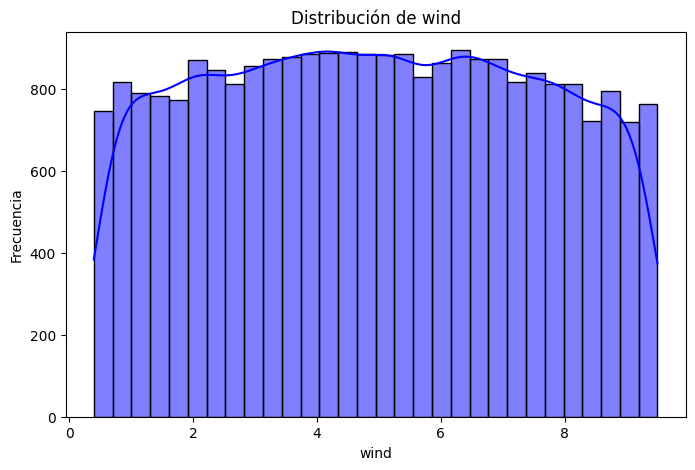

In [34]:
# Estadísticas descriptivas de las columnas que contenian nulos
cols_nulos = ['precipitation', 'temp_max', 'temp_min', 'wind']
print(df_full[cols_nulos].describe())

# Histograma de cada columna
for col in cols_nulos:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_full[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

**VISUALIZAR LOS DATOS QUE RESALTAN EN EL GRÁFICO DE CORRELACIONES**

WEATHER ID

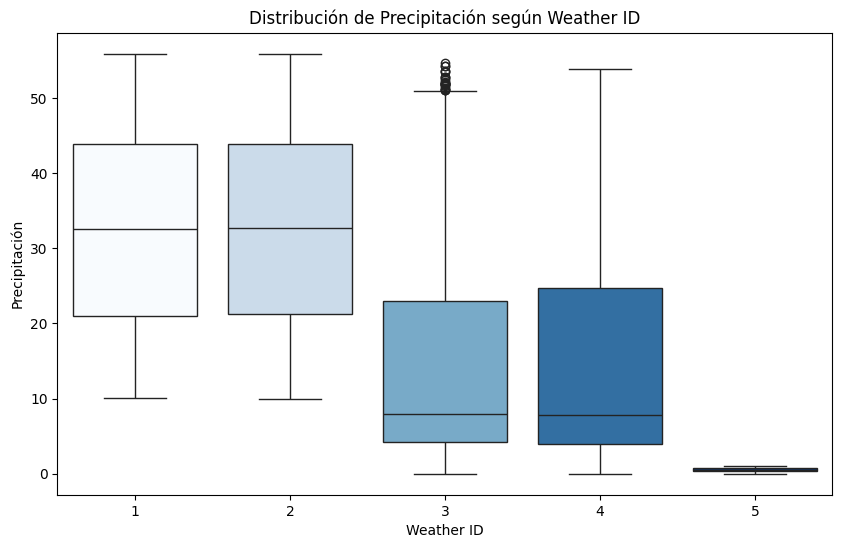

In [35]:
# Boxplot de weather_id vs precipitación
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='precipitation', hue='weather_id', data=df_full, palette='Blues', legend=False)
plt.title('Distribución de Precipitación según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Precipitación')
plt.show()

PRECIPITATION

C:\Users\joant\AppData\Local\Temp\ipykernel_12332\1236109381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='weather_id', y='wind', data=df_full, palette='Greens')


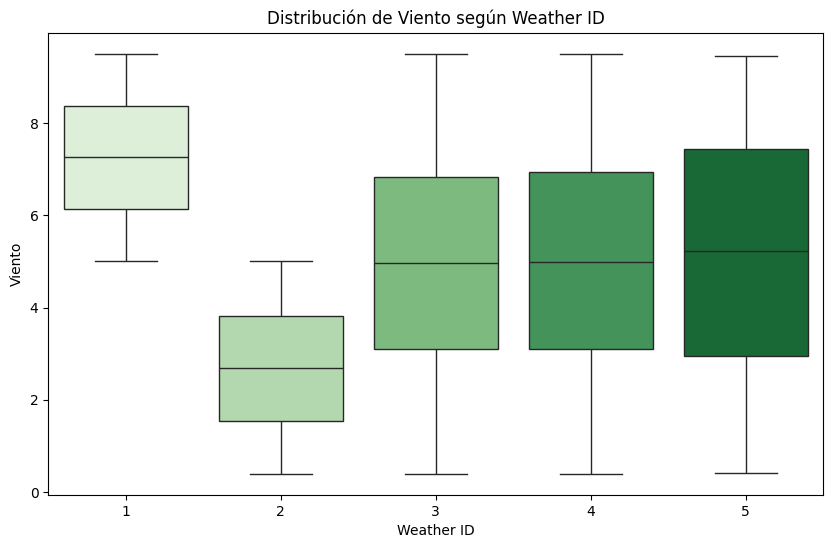

In [36]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='weather_id', y='wind', data=df_full, palette='Greens')
plt.title('Distribución de Viento según Weather ID')
plt.xlabel('Weather ID')
plt.ylabel('Viento')
plt.show()

WEATHER ID vs WIND

C:\Users\joant\AppData\Local\Temp\ipykernel_12332\648945662.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cloudiness_id', y='solar_radiation', data=df_full, palette='Reds')


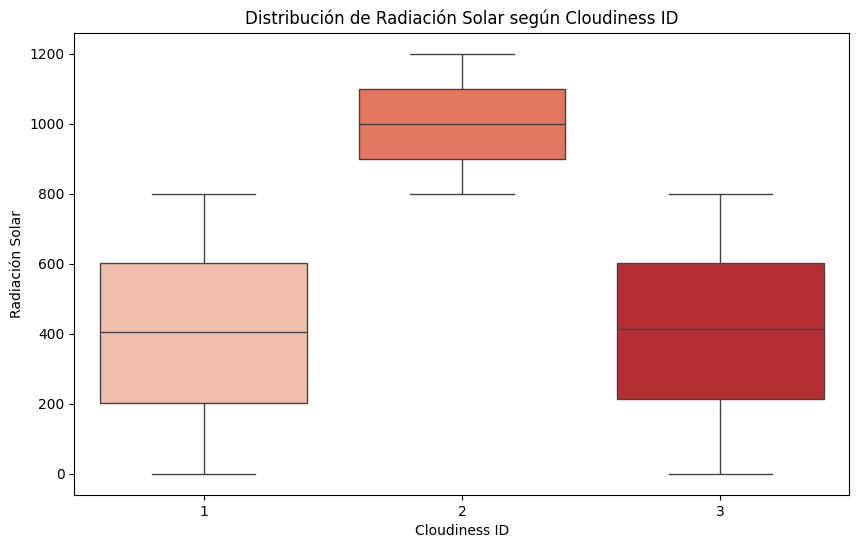

In [37]:
# Boxplot de weather_id vs viento
plt.figure(figsize=(10, 6))
sns.boxplot(x='cloudiness_id', y='solar_radiation', data=df_full, palette='Reds')
plt.title('Distribución de Radiación Solar según Cloudiness ID')
plt.xlabel('Cloudiness ID')
plt.ylabel('Radiación Solar')
plt.show()

## AÑADIR INDICES EXTRAS

In [38]:
# Temperatura media
df_observations['temp_avg'] = (df_observations['temp_max'] + df_observations['temp_min']) / 2

# Incremento de temperatura
df_observations['temp_incr'] = df_observations['temp_max'] - df_observations['temp_min']

df_observations.to_csv(r".\..\..\Datos_Proyecto\observations_full.csv", index=False)

GRAFICO DE CORRELACION CON LOS NUEVOS INDICES CALCULADOS

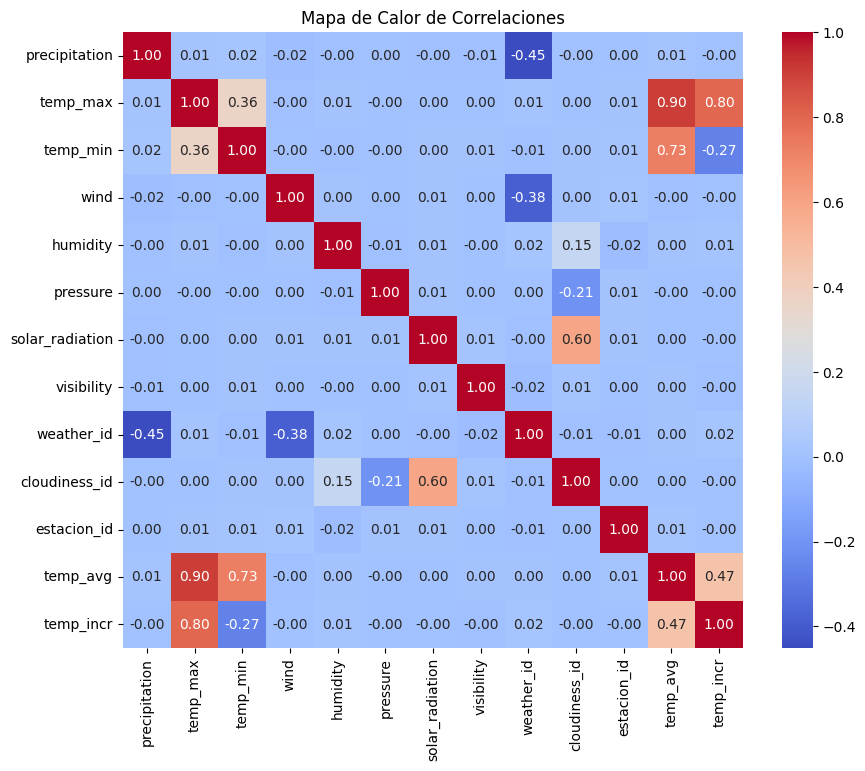

In [40]:
df_full = pd.read_csv(r".\..\..\Datos_Proyecto\observations_full.csv")

numerical_data = df_full.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

**CARGAR LOS DATOS SQL Y CREAR LOS GRAFICOS**

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect(r"C:\Users\joant\OneDrive\Stucom\MasterIA\BigData\Projecte3_Meteorologia\Entregables\Code\weather.db")

# Cargar cada tabla en un DataFrame de pandas
df_cloudiness = pd.read_sql_query("SELECT * FROM cloudiness", conn)
df_dates = pd.read_sql_query("SELECT * FROM dates", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations_full", conn)
df_weather = pd.read_sql_query("SELECT * FROM weather", conn)
df_seasons = pd.read_sql_query("SELECT * FROM seasons", conn)

# Cerrar la conexión cuando hayas terminado
conn.close()

# Unir las tablas usando merge
df = df_observations \
    .merge(df_dates, on='date_id') \
    .merge(df_weather, on='weather_id') \
    .merge(df_cloudiness, on='cloudiness_id') \
    .merge(df_seasons, on='estacion_id')


OperationalError: unable to open database file

DISTRIBUCIÓN DE LAS TEMPERATURAS MAXIMAS

In [ ]:
# Graficar un histograma de temperatura máxima
plt.figure(figsize=(10, 6))
sns.histplot(df['temp_max'].dropna(), bins=30, kde=True)
plt.title("Distribución de Temperatura Máxima")
plt.xlabel("Temperatura Máxima (°C)")
plt.ylabel("Frecuencia")
plt.show()

TEMPERATURA MAX/MIN POR FECHA

In [ ]:
# Convertir la columna de fechas a tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Graficar temperatura máxima y mínima a lo largo del tiempo
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='temp_max', data=df, label='Temp Max')
sns.lineplot(x='date', y='temp_min', data=df, label='Temp Min')
plt.title("Temperatura Máxima y Mínima a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

HUMEDAD POR CONDICION CLIMATICA

In [ ]:
# Calcular la humedad promedio por tipo de clima
df_weather_humidity = df.groupby('weather')['humidity'].mean().reset_index()

# Graficar la humedad promedio por tipo de clima
plt.figure(figsize=(10, 6))
sns.barplot(x='humidity', y='weather', hue='weather', data=df_weather_humidity, palette="viridis", legend=False)
plt.title("Humedad Promedio por Condición Climática")
plt.xlabel("Humedad (%)")
plt.ylabel("Condición Climática")
plt.show()

TEMPERATURA MÁXIMA POR TIPO DE TIEMPO

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='temp_max', hue='weather', data=df, palette="Set3", legend=False)
plt.title("Distribución de Temperatura Máxima por Condición Climática")
plt.xlabel("Condición Climática")
plt.ylabel("Temperatura Máxima (°C)")
plt.show()

VIENTO vs PRESIÓN

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind', y='pressure', hue='cloudiness', data=df, palette="bright")
plt.title("Viento vs. Presión según Nubosidad")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Presión (hPa)")
plt.legend(title="Nubosidad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

PRECIPITACION POR VIENTO Y TIPO DE TIEMPO

In [ ]:
# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(x='wind', y='precipitation', hue='weather', data=df, palette="Set2", s=50)
plt.title("Precipitación vs. Viento por Weather")
plt.xlabel("Velocidad del Viento (m/s)")
plt.ylabel("Precipitación (mm)")
plt.legend(title='Tipo de Tiempo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


PRECIPITACIÓN POR TIPO DE TIEMPO

In [ ]:
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x='weather', y='precipitation', hue='weather', data=df, palette="viridis", legend=False)
plt.title("Precipitación Promedio por Weather")
plt.xlabel("Tipo de Tiempo")
plt.ylabel("Precipitación Promedio (mm)")
plt.xticks(rotation=45)
plt.show()

TEMPERATURA PROMEDIO POR MES

In [ ]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('month').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='month', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='month', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Mes")
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.xticks(ticks=df_temp_by_month['month'], labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.legend()
plt.show()


TEMPERATURA PROMEDIO POR AÑO

In [ ]:
# CONVERTIR date A datetime
df['date'] = pd.to_datetime(df['date'])

# EXTRAER MES Y AÑO
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# AGRUPAR POR MES Y CALCULAR LA TEMPERATURA PROMEDIO
df_temp_by_month = df.groupby('year').agg({'temp_max': 'mean', 'temp_min': 'mean'}).reset_index()

# MOSTRAR GRAFICO
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_temp_by_month, x='year', y='temp_max', marker='o', label='Temp Max', color='red')
sns.lineplot(data=df_temp_by_month, x='year', y='temp_min', marker='o', label='Temp Min', color='blue')
plt.title("Temperatura Promedio por Año")
plt.xlabel("Year")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()


VARIABILIDAD DE LA VISIBILIDAD POR CONDICIÓN CLIMÁTICA

In [ ]:
# Grafica de la visibilidad por condición climática
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weather', y='visibility', hue='weather_id', palette="viridis", legend=False)
plt.title('Variabilidad de la Visibilidad por Condición Climática')
plt.xlabel('Condición Climática')
plt.ylabel('Visibilidad')
plt.grid(axis='y')
plt.show()


TEMPERATURA MÁXIMA Y MÍNIMA PROMEDIO POR ESTACIÓN DEL AÑO

In [ ]:
# Temperatura promedio por estación
temp_seasonal_avg = df.groupby('estacion')[['temp_max', 'temp_min']].mean()

# Gráfica de barras para temperatura máxima y mínima por estación
plt.figure(figsize=(10, 6))
temp_seasonal_avg.plot(kind='bar', color=['#ff8f1e','#47bfff'])
plt.title('Temperatura Máxima y Mínima Promedio por Estación del Año')
plt.xlabel('Estación')
plt.xticks(ticks=range(4), labels=['Invierno', 'Primavera', 'Verano', 'Otoño'], rotation=0)
plt.ylabel('Temperatura Promedio')
plt.legend(['Temp Max', 'Temp Min'])
plt.grid(axis='y')
plt.show()


                  date_id  precipitation  temp_max  temp_min      wind  \
date_id          1.000000      -0.003374 -0.002420 -0.003786  0.004160   
precipitation   -0.003374       1.000000  0.008682  0.015983 -0.018493   
temp_max        -0.002420       0.008682  1.000000  0.363156 -0.004227   
temp_min        -0.003786       0.015983  0.363156  1.000000 -0.002211   
wind             0.004160      -0.018493 -0.004227 -0.002211  1.000000   
humidity         0.003193      -0.003474  0.006458 -0.003690  0.003550   
pressure        -0.002679       0.000046 -0.002715 -0.001700  0.002124   
solar_radiation -0.012761      -0.003494  0.000598  0.003267  0.006620   
visibility      -0.001597      -0.005249  0.000925  0.006844  0.000122   
weather_id      -0.103623      -0.450753  0.011299 -0.008294 -0.384830   
cloudiness_id   -0.007821      -0.001903  0.000633  0.003837  0.004875   
estacion_id      0.005205       0.000528  0.005980  0.012424  0.014665   
year            -0.001525       0.0056

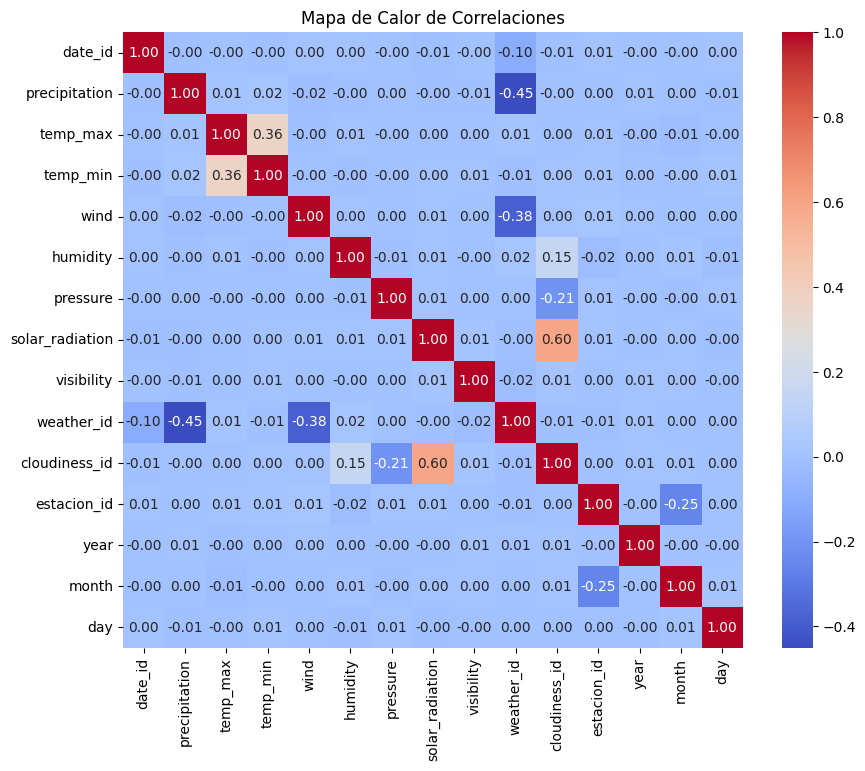

,date_id,precipitation,temp_max,temp_min,wind,humidity,pressure,solar_radiation,visibility,weather_id,cloudiness_id,estacion_id,year,month,day
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,27.705473,16.945308,3.639998,4.925901,65.146117,1014.978395,602.463700,10.006298,1.924320,1.416040,2.501120,1989.961520,6.517240,15.73300
std,7217.022701,15.627353,10.429545,6.501064,2.562881,20.242138,20.072576,345.501415,5.768604,0.836696,0.568862,1.119557,19.889204,3.445963,8.79795
min,1.000000,0.000950,-1.599122,-7.099699,0.400440,30.002654,980.001069,0.047580,0.000309,1.000000,1.000000,1.000000,1956.000000,1.000000,1.00000
25%,6250.750000,14.549274,8.182007,-1.673610,2.758433,47.719111,997.633398,301.462691,5.040118,1.000000,1.000000,2.000000,1973.000000,4.000000,8.00000
50%,12500.500000,27.485519,16.936219,2.849228,4.913406,64.996337,1015.071486,604.615817,10.033430,2.000000,1.000000,2.000000,1990.000000,7.000000,16.00000
75%,18750.250000,40.736396,25.683873,8.489202,7.089572,82.799226,1032.304535,900.851006,14.964128,3.000000,2.000000,4.000000,2007.000000,10.000000,23.00000
max,25000.000000,55.899713,35.599908,18.297301,9.498636,99.998912,1049.996959,1199.876586,19.998866,5.000000,3.000000,4.000000,2024.000000,12.000000,31.00000


In [3]:
df = pd.read_csv(r'.\..\..\Datos_Proyecto\observations_full.csv')

df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.drop('date',axis=1,inplace=True)

correlation_matrix = df.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

df.describe()